In [1]:
%matplotlib inline

import io
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision import datasets, models, transforms

from exercise05.model import ConvNet, Net

device = torch.device("cpu")

In [2]:
np.random.seed(42)
torch.manual_seed(42)

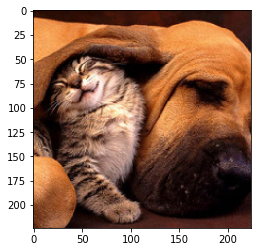

In [3]:
# load everything that we need
# here we load alexnet, an already trained neural network
# you can play with other models in models.*, but for some of the others it is harder
# to get the activations in the middle of the network
alexnet = models.alexnet(pretrained=True)

# define a 'layer' to normalize an image such that it is usable by the network
class Normalize(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.mean = torch.Tensor([0.485, 0.456, 0.406]).float().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        self.std = torch.Tensor([0.229, 0.224, 0.225]).float().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    
    def forward(self, x):
        b, c, h, w = x.shape
        mean = self.mean.expand(x.shape)
        std = self.std.expand(x.shape)
        return (x - self.mean)/self.std

# define a layer that flattens whatever it gets passed into a vector
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# function that takes our pre-processed image and computes a numpy matrix that we can plot as an image
def img2numpy(x):
    x = x.clone().squeeze()
    x = x.detach().numpy()
    x = np.transpose(x, (1, 2, 0))
    return x

# preprocess an image for the network
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor()
])

# download an image from flickr
response = requests.get("http://c1.staticflickr.com/5/4070/5148597478_0c34ec0b7e_n.jpg")
image = Image.open(io.BytesIO(response.content))
image = preprocess(image).unsqueeze(0)
plt.imshow(img2numpy(image))

In [4]:
# download a mapping of the imagenet class ids to text
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
imagenet_classes_request = requests.get("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt")

In [5]:
# turn the downloaded id-to-text mapping into a dict
# before running this really inspect the output of the above comment
# you are about to run something downloaded from the internet
# run at your own risk
imagenet_classes = eval(imagenet_classes_request.content)

In [6]:
# try out the neural network
# we want to run our normalize layer first and then alexnet
model = nn.Sequential(Normalize(), alexnet)
logits = model(image)
t = alexnet(Normalize()(image)).detach().numpy().ravel().argsort()[::-1][:5]
print('Top 5 classes for image:')
print(list(map(lambda x: imagenet_classes[x], t.tolist())))

Top 5 classes for image:
['bull mastiff', 'redbone', 'bloodhound, sleuthhound', 'black-and-tan coonhound', 'boxer']


We now take a closer look at the layers in the alexnet model.
alexnet has two parts 'features' and 'classifier' where features is the convolutional part of the neural network.

In [7]:
alexnet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [8]:
alexnet.classifier

Sequential(
  (0): Dropout(p=0.5)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [9]:
# we see that we can use the individual parts of alexnet
# but we need to add a Flatten() layer between the two parts
model = nn.Sequential(Normalize(), alexnet.features, Flatten(), alexnet.classifier)
logits = model(image)
t = alexnet(Normalize()(image)).detach().numpy().ravel().argsort()[::-1][:5]
print('Top 5 classes for image:')
print(list(map(lambda x: imagenet_classes[x], t.tolist())))

Top 5 classes for image:
['cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'Labrador retriever', 'bull mastiff', 'beagle', 'pug, pug-dog']


In [10]:
def gradcam(model, image, layer, target, treshold=0.5):
    """
    This method takes:
    model - an alexnet
    image - an input image
    layer - an integer that indexes alexnet.features; this gives the layer that we use for the algorithm
    target - the target class for visualization
    treshold - how much of the heat map to show in the overlayed image
    """
    # TODO implement this function
    # General approach:
    # - split the model into two parts: before the targeted layer, and after
    # - create an optimizeable variable/tensor from the output of the first part
    # - run it through the second part (you probably need to run layer_activations.clone() instead of layer_activations due to how pytroch behaves)
    # - call backward on the right value and obtain the gradient
    # - from there follow the algorithm from the slide/paper
    
    assert 1 <= layer <= 12 # layer is valid index into alexnet.features
    
    model.eval()
    model.zero_grad()
    
    # split model into two parts
    model_part_1 = nn.Sequential(Normalize(), model.features[:layer+1])
    model_part_2 = nn.Sequential(model.features[layer+1:], Flatten(), model.classifier)
    
    # extract the activation at the requested layer
    layer_activations = model_part_1(image).detach()
    layer_activations.requires_grad_()
    
    # compute forward pass through the rest of the network
    logits = model_part_2(layer_activations.clone())
    
    # compute gradient from target logit
    logits[0, target].backward()
    
    # compute weights alpha
    G = layer_activations.grad
    layer_shape = G.shape
    alpha = G.reshape(layer_shape[:2] + (-1,)).mean(2)
    
    # compute activation map
    L = alpha.unsqueeze(-1).unsqueeze(-1).repeat((1,1) + layer_shape[2:]) * layer_activations
    L = L.sum(1).relu().detach().numpy()[0, ...]
    
    # create transparent heatmap for visualization
    L_transparent = np.tile(L[:, :, None], (1, 1, 4))
    L_transparent[:, :, 0] /= L_transparent[:, :, 0].max()
    L_transparent[:, :, 1] /= L_transparent[:, :, 1].max()
    L_transparent[:, :, 2] /= L_transparent[:, :, 2].max()
    L_transparent[:, :, 3] = L_transparent[:, :, 3] > treshold * L_transparent[:, :, 3].max()
    L_transparent = cv2.resize(L_transparent, dsize=image.shape[2:], interpolation=cv2.INTER_NEAREST)
    
    # show the results
    f, axarr = plt.subplots(1,3, figsize=(18, 6))
    f.suptitle('Visualization for Class: ' + imagenet_classes[target], fontsize=16)
    axarr[0].imshow(img2numpy(image))
    axarr[0].set_title('Original Image')
    axarr[1].imshow(L, interpolation='nearest')
    axarr[1].set_title('Heatmap')
    axarr[2].imshow(img2numpy(image))
    axarr[2].imshow(L_transparent)
    axarr[2].set_title('Overlay') 
    

## Visualizing different classes

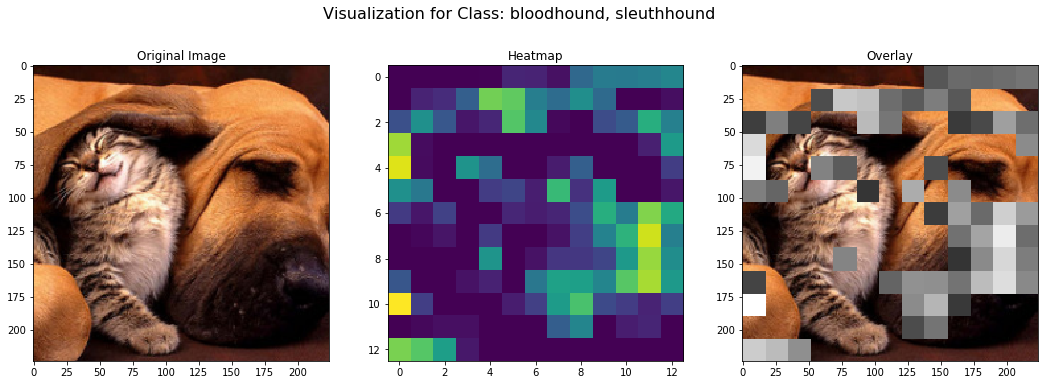

In [11]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 9, s, treshold=0.2)

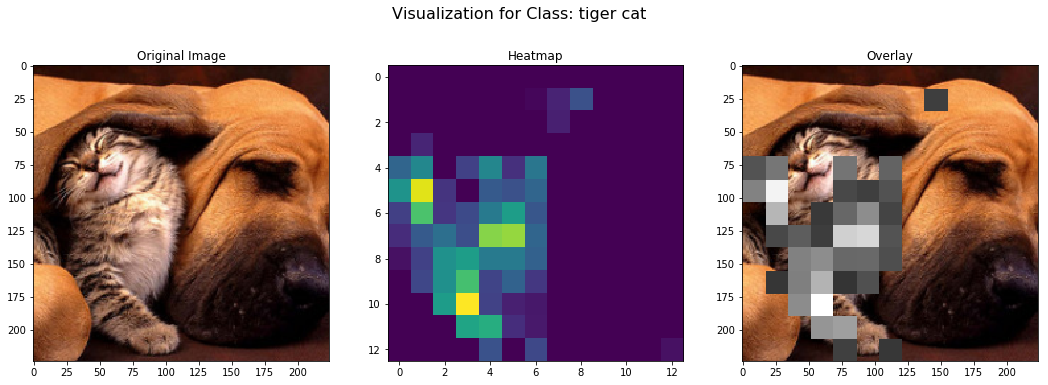

In [12]:
s = 282 #tiger cat
gradcam(alexnet, image, 9, s, treshold=0.2)

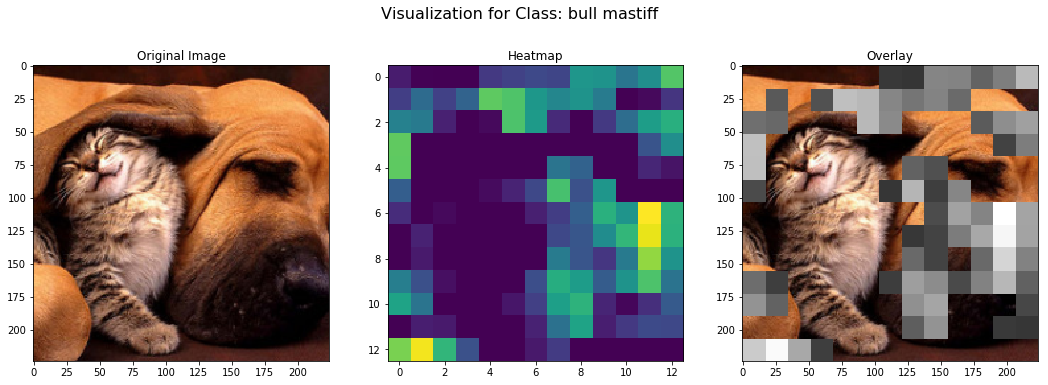

In [13]:
s = 243 #'bull mastiff'
gradcam(alexnet, image, 9, s, treshold=0.2)

## Visualizing one class for various different layers

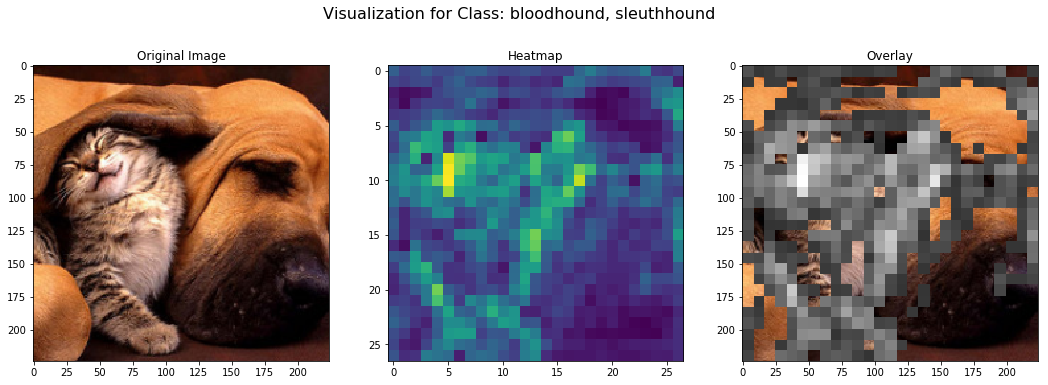

In [14]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 2, s, treshold=0.2)

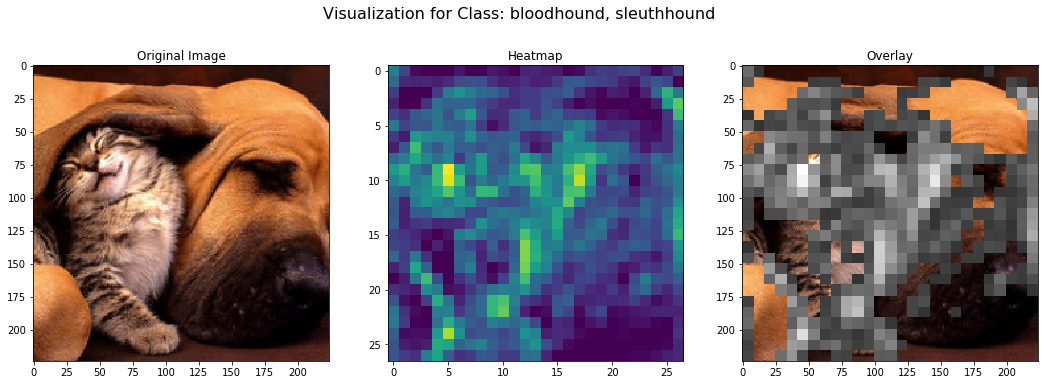

In [15]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 3, s, treshold=0.2)

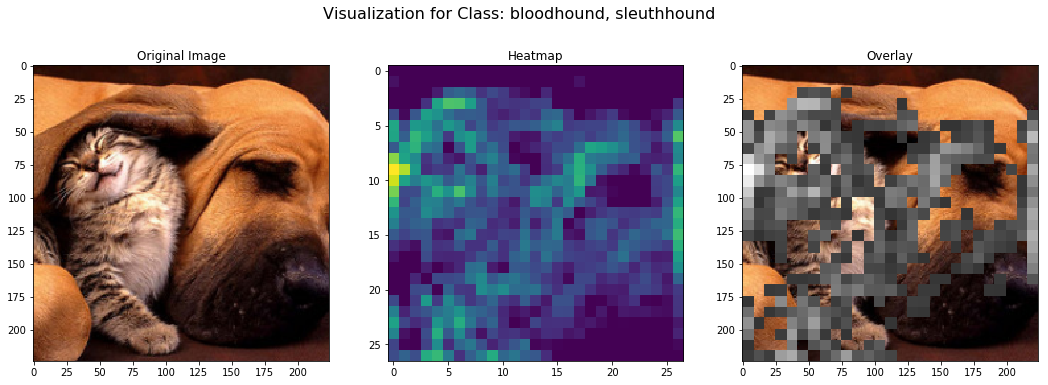

In [16]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 4, s, treshold=0.2)

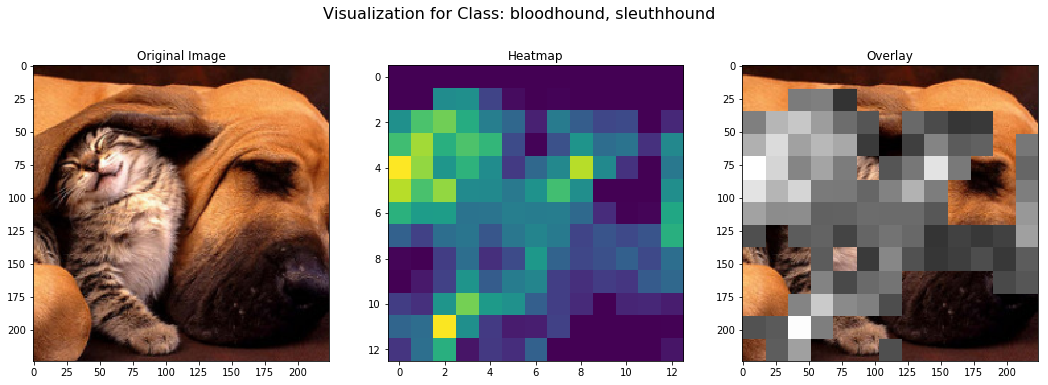

In [17]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 5, s, treshold=0.2)

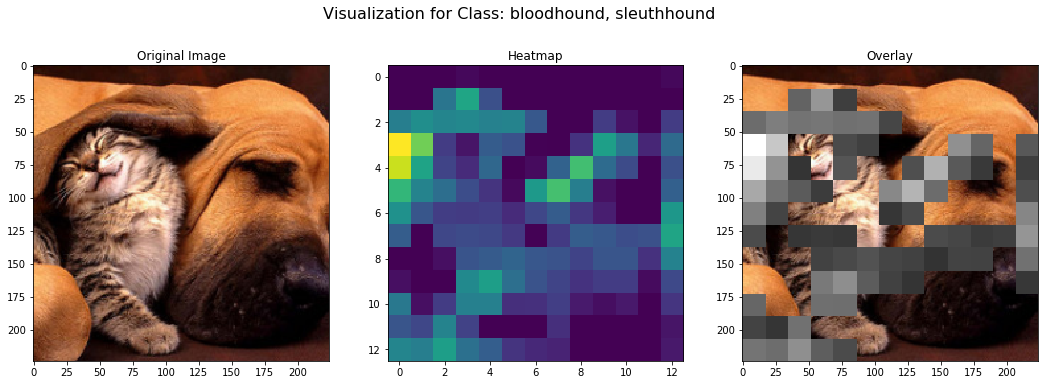

In [18]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 6, s, treshold=0.2)

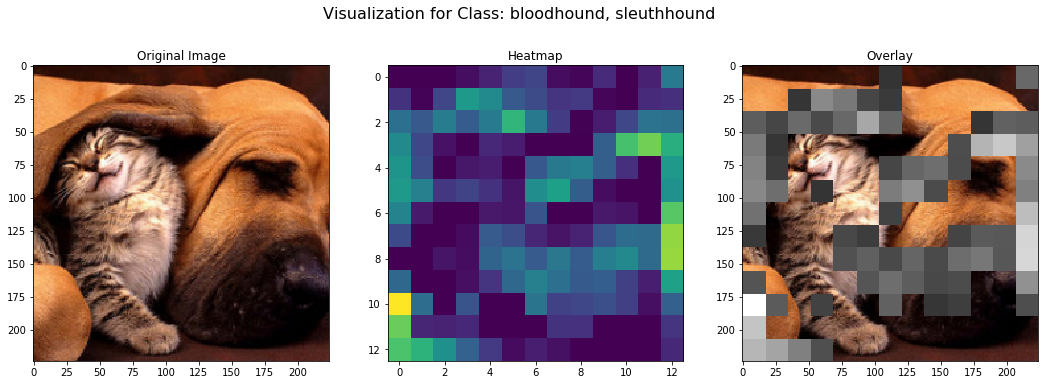

In [19]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 7, s, treshold=0.2)

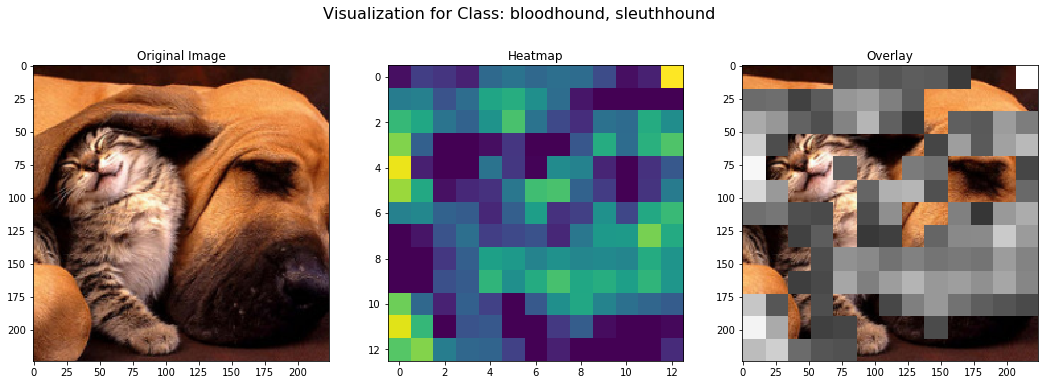

In [20]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 8, s, treshold=0.2)

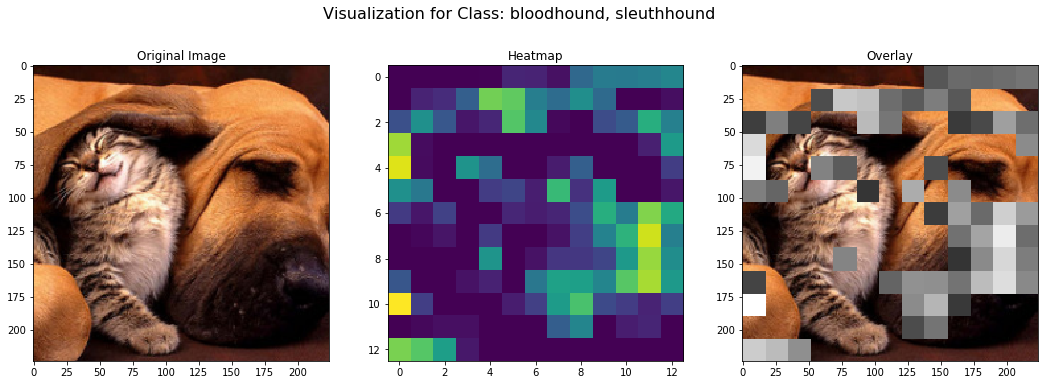

In [21]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 9, s, treshold=0.2)

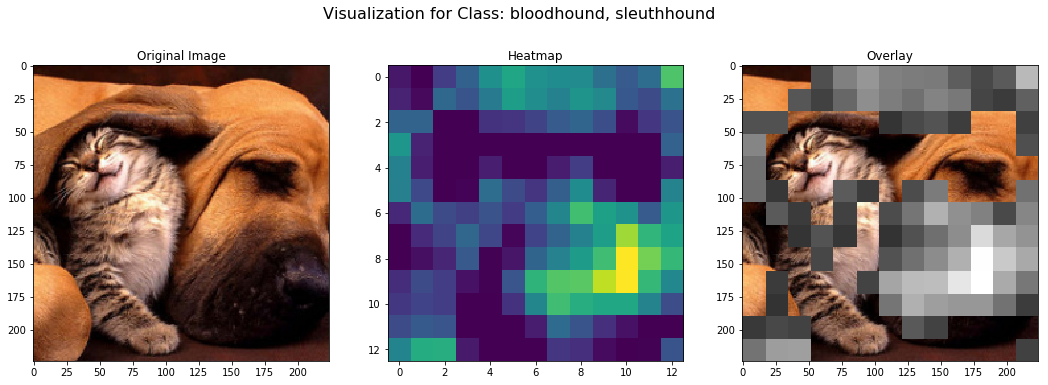

In [22]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 10, s, treshold=0.2)

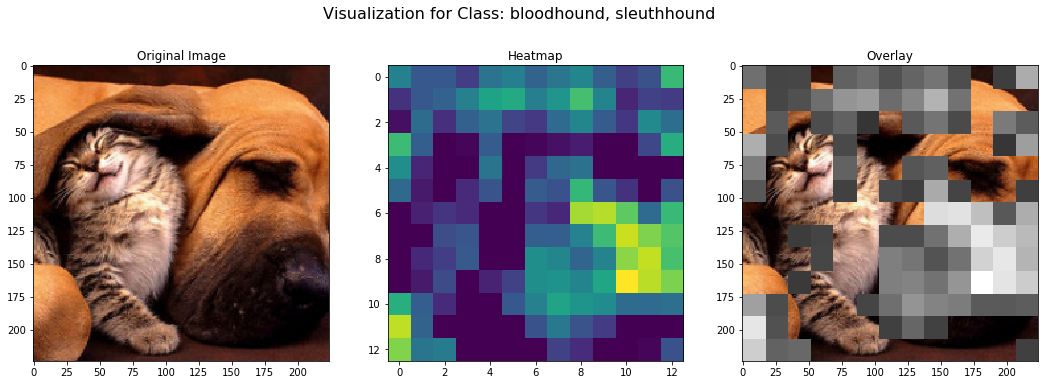

In [23]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 11, s, treshold=0.2)

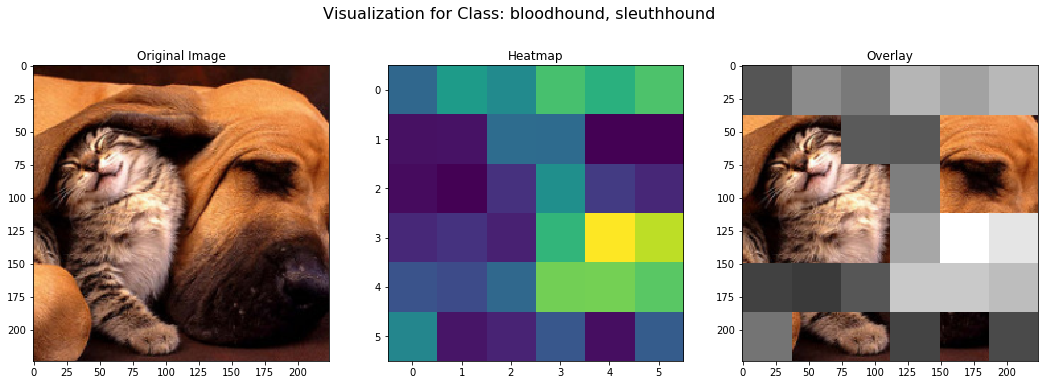

In [24]:
s = 163 #'bloodhound, sleuthhound'
gradcam(alexnet, image, 12, s, treshold=0.2)